# EEE3027 Embedded Systems - Programming Lab 3

This is the third introductory lab for the second part of this module, where we will focus on how to implement a Machine Learning (ML) model using Python.

For the purposes of your coursework, this example will be based on the **Long Short-Term Memory (LSTM) Recurrent Neural Network (RNN)**.

> **_NOTE:_** As this is not an ML course, we will not be covering LSTMs in full detail nor the actual mathematics involved in the LSTM. For your purposes, you can treat the LSTM as another 'black box' tool that reads in your input and produces some output from it. The key difference is that the result of this tool is non-deterministic and is entirely dependent on the data, its parameters, and how it is trained.
>
> For interested students who wish to learn more about LSTMs and want to dive deep into the world of ML, we encourage you to read the [original LSTM paper](https://ieeexplore.ieee.org/abstract/document/6795963) or take a look at [Colah's blog on LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

## A very simple illustration of how ML models work

As mentioned in the note above, you can view the ML model as a 'black box' tool that you use to feed in some input to produce some output, where the output maybe non-deterministic and is dependent on the data given, the parameters for the ML model, and how it is trained (e.g. what are its features (i.e. some numerical property/characteristic that is relatable) and its labels (i.e. the values associated with these properties/characteristics).

Typically, these ML models will go through some training process to learn from the data that is given to it and then *hopefully* produce the desired outcome, when it is inferred. To help illustrate this, the figure below shows a very naive view of how data is fed into an ML model (e.g. say our LSTM RNN) which is then trained sufficiently until we get a 'finalised' ML model that we use to infer and produce results.

![Diagram that shows a very simplistic overview of how an ML model is trained, where some data is given and the model is then trained to eventually produce some result.](training.svg)

## Objectives

From this tutorial, you will...

- ...gain an idea how to begin building an ML model (more specifically, the LSTM) from loading and preprocessing the data to training and infering the ML model.
- ...start to identify the different components that are typically used within an ML implementation, which you will need to eventually break it down into separate concurrent processes.
- ...begin to write up your (initial) Petri net description of your implementation via Workcraft.

# Prerequisites

In order to complete this tutorial, you will need to install the following libraries if you have not done so already.

> **_NOTE:_** These installation instructions assume that you *do not* have any of the libraries installed (including Jupyter Notebook since you can technically open it through Visual Studio Code) and plan to install it through a separate Python environment (as it is usually a good idea to create separate Python environments for different works).
>
> The following instructions *should* work for both Linux and MacOS environments, with some alterations for the Windows environment.

```bash
mkdir labs
cd labs
python3 -m venv LAB_ENVIRONMENT
source LAB_ENVIRONMENT/bin/activate
pip3 install torch
pip3 install jupyter
pip3 install numpy
pip3 install pandas
pip3 install seaborn
pip3 install scikit-learn
```

With the setup above, you want to run the notebook by going to this ```labs``` directory and type in: ```source LAB_ENVIRONMENT/bin/activate```.

## 1. Import the necessary libraries.

Like in your previous exercises, you can simply import the libraries like below.

> **_NOTE:_** Remember that you need to install the libraries above or there will be trouble! ~~No seriously I mean it...~~

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## 2. Configure the implementation to execute on either the CPU or the GPU.

Generally, it is *faster* to run your implementation(s) on the GPU rather than the CPU. By default, your implementation(s) will always run on the CPU unless you tell it otherwise. If your machine has a decent/good GPU available e.g. say an NVidia XX60+ card or an AMD X600+ card series, then you may want to run your implementation on the GPU and leverage of the GPU training benefits. **However, please do not feel pressured to use the GPU - it is entirely sufficient to use the CPU for the purposes of your coursework. This is only if you wish to train your ML models that bit faster.**

Assuming your Pytorch libraries are installed with GPU capabilities, you will be able to run a similar command like below.

> **_Disclaimer!_**
>
> The reason why I said a *similar command like below* is because the GPU configuration of Pytorch for Windows and Linux is actually slightly different than the Mac OS, since Macs have their own in-built GPU.
>
> Another thing is that the GPU configuration of Pytorch for Windows and Linux is dependent on Nvidia's CUDA toolkit (or at least as far as I am aware since I have not been able to test with an AMD GPU...), so you will need to check if your device is compatible with these other requirements.
>
> With that out of the way:
>
> - If you have a Windows machine or a Linux machine and you are confident that you have an NVidia GPU then run:
> - ```device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")```
>
> - If you have a Mac machine then run:
> - ```device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")```
>
> - If you are skeptical of the above commands and/or do not wish to use the GPU at all then run:
> - ```device = torch.device("cpu")```

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use if your machine is Windows or Linux
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # Use if your machine is Mac
print(device) # Debugging to check if the device is set up correctly!

mps


## 3. Load and preprocess your data.
For this step, loading the data is extremely simple - But, how this data works with the ML model is the tricky bit, since while some ML models could thereotically work out-of-the-box with the 'raw' data, this may often lead to several issues including inaccuracy, overfitting, underfitting, etc.

The key to ensure that the ML model is actually learning is by properly pre-processing such raw data into a format that can be understood by the ML model and to select what *attributes* we want it to learn.

Unfortunately, there is not a concrete step to pre-process data - every ML model is different and it is ultimately up to the designer to identify the issues and understand how to resolve them. Sometimes the problem is very simple and just requires a minor adjustment, other times you may need to trial-and-error.

Generally, you will need to identify what are your 'features' (i.e. the measurable property/characteristic of a dataset you want to target) and what are your 'labels' (i.e. the actual value related to the feature). Then, pre-process this data (e.g. are there any null values? If so, clean them! Do you need to scale it? Do so!).

> **_Note:_** Remember this course is not an ML module, so we will not expect you to know what are your features and labels straight away, nor identify what pre-processing steps you will need in order for your ML model to function. This will come in due time as you progress through the remaining weeks and implement your solution.

In [ ]:
weather = pd.read_csv('london_weather.csv')

In [ ]:
weather

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
15336,20201227,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,NaN
15337,20201228,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,NaN
15338,20201229,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN
15339,20201230,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,NaN


In [ ]:
weather['date'] = pd.to_datetime(weather['date'], format='%Y%m%d') # Turn the date string objects into actual datetime objects

In [ ]:
weather

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
15336,2020-12-27,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,NaN
15337,2020-12-28,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,NaN
15338,2020-12-29,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN
15339,2020-12-30,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,NaN


In [ ]:
weather['snow_depth'] = weather['snow_depth'].fillna(0) # Assume there are no snow for NaN values in snow depth

In [ ]:
weather

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
15336,2020-12-27,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,0.0
15337,2020-12-28,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,0.0
15338,2020-12-29,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,0.0
15339,2020-12-30,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,0.0


In [ ]:
print(weather.isna().sum())                # Count number of NaN values
print(weather[weather.isna().any(axis=1)])

date                 0
cloud_cover         19
sunshine             0
global_radiation    19
max_temp             6
mean_temp           36
min_temp             2
precipitation        6
pressure             4
snow_depth           0
dtype: int64
            date  cloud_cover  sunshine  global_radiation  max_temp  \
14    1979-01-15          NaN       0.0              15.0       5.9   
20    1979-01-21          NaN       0.0              16.0       1.5   
37    1979-02-07          NaN       0.0              21.0       3.7   
50    1979-02-20          NaN       0.0              27.0       3.6   
56    1979-02-26          NaN       4.2              82.0       8.9   
...          ...          ...       ...               ...       ...   
15131 2020-06-05          4.0       1.2             194.0      16.5   
15172 2020-07-16          6.0       1.0             133.0       NaN   
15197 2020-08-10          3.0      10.9             290.0       NaN   
15256 2020-10-08          7.0       5.1        

In [ ]:
weather.dropna(inplace=True) # Remove the NaN values
weather.info

<bound method DataFrame.info of             date  cloud_cover  sunshine  global_radiation  max_temp  \
0     1979-01-01          2.0       7.0              52.0       2.3   
1     1979-01-02          6.0       1.7              27.0       1.6   
2     1979-01-03          5.0       0.0              13.0       1.3   
3     1979-01-04          8.0       0.0              13.0      -0.3   
4     1979-01-05          6.0       2.0              29.0       5.6   
...          ...          ...       ...               ...       ...   
15336 2020-12-27          1.0       0.9              32.0       7.5   
15337 2020-12-28          7.0       3.7              38.0       3.6   
15338 2020-12-29          7.0       0.0              21.0       4.1   
15339 2020-12-30          6.0       0.4              22.0       5.6   
15340 2020-12-31          7.0       1.3              34.0       1.5   

       mean_temp  min_temp  precipitation  pressure  snow_depth  
0           -4.1      -7.5            0.4  101900

In [ ]:
weather.isna().sum()

date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64

## 4. Splitting the input/target data into a training set and a testing set.

In order for the ML model to actually learn from your given data, you will also need to validate it against the data itself. However, simply feeding the whole data as both the training and testing data into the ML model is incorrect as they can lead to the ML model being overfitted and/or learning the patterns specifically tied to the data (meaning it will likely underperform when you introduce new data).

To avoid this, you will need to split the data into an appropriate ratio of training data and testing data. For our purposes, a 80/20 split will be sufficient.

In [ ]:
input_data = weather.drop(['date'], axis=1)
print(input_data)

       cloud_cover  sunshine  global_radiation  max_temp  mean_temp  min_temp  \
0              2.0       7.0              52.0       2.3       -4.1      -7.5   
1              6.0       1.7              27.0       1.6       -2.6      -7.5   
2              5.0       0.0              13.0       1.3       -2.8      -7.2   
3              8.0       0.0              13.0      -0.3       -2.6      -6.5   
4              6.0       2.0              29.0       5.6       -0.8      -1.4   
...            ...       ...               ...       ...        ...       ...   
15336          1.0       0.9              32.0       7.5        7.5       7.6   
15337          7.0       3.7              38.0       3.6        1.1      -1.3   
15338          7.0       0.0              21.0       4.1        2.6       1.1   
15339          6.0       0.4              22.0       5.6        2.7      -0.1   
15340          7.0       1.3              34.0       1.5       -0.8      -3.1   

       precipitation  press

In [ ]:
targets = weather['mean_temp'].values
print(targets)

[-4.1 -2.6 -2.8 ...  2.6  2.7 -0.8]


In [ ]:
T = 20                    #Number of timesteps to look while predicting
D = input_data.shape[1]   #Dimensionality of the input
N = len(input_data) - T
print(f'Dimensions are {T} × {D} × {N}')

Dimensions are 20 × 9 × 15241


In [ ]:
#Train size: 80% of the total data size
train_size = int(len(input_data) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])
input_data = scaler.transform(input_data)

In [ ]:
# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
  X_train[t, :, :] = input_data[t:t+T]
  y_train[t] = (targets[t+T])

In [ ]:
# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = input_data[t:t+T]
  y_test[i] = (targets[t+T])

In [ ]:
# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

## 5. Creating the LSTM model

With our training and testing data now properly prepared, we can now begin implementing our LSTM model. But, before we continue, let us briefly return to technical side and understand what is an LSTM, how it works, and its structure.

### a. What is an LSTM?

LSTM is a type of RNN that aims to mitigate the vanishing gradient problem, which is commonly encountered in traditional RNNs. The vanishing gradient problem is essentially where the gradients used to update the RNN become so small that it no longer updates the weights of the RNN sufficiently, which can lead to loss of 'memory'. The way that LSTM addresses this is by improving the architecture in such a way where we not only have our working memory (i.e. short-term memory) but also our carry-on memory (i.e. long-term memory).

### b. How does the memory in LSTMs work?

In the LSTM, there are three key gates:

1. The Forget Gate manages what should be forgotten.
2. The Input Gate manages what should be kept, and
3. The Output Gate manages what information is stored in the carry and hidden states.

Each of these gates comprise of their own neural network layer that handles the mathematics needed to retain the relevant data we need to store in both the short-term memory and long-term memory. Again, as mentioned above, we will *not* be covering the

The above is illustrated in the diagram below.

![A diagram depicting the structure of an LSTM cell](lstm-cell.svg)

### c. How does the LSTM work?

Remember that the LSTM is just a special type of RNN - Like how recursive functions typically work, our LSTM 'recursively' handles all the data provided until the last datapoint is reached (leading to a completion of one epoch).

In fact, when we look at how RNNs/LSTMs are structured, we can view the RNN/LSTM as a singular cell that consist of the previous carry state, previous hidden state and data as its input and the next carry state and next hidden state as its output, which is directly fed back into the LSTM as part of its input. This can lead to this 'folded' structure illustrated in the diagram below on the left.

Now, if we 'unfold' this structure as illustrated in the diagram below on the right, we can 'break up' our LSTM up to **_n_** separate processes that occur at each (time) step. This leads to what we call an 'unfolded' structure.

![A diagram depicting both the folded and unfolded structure of an LSTM archtecture](lstm-architecture.svg)


## 5. Creating the LSTM model (continued)

Now, back to the actual implementation, we will need to refer Pytorch's library to create our LSTM.

The code below shows how we can create an instance of a defined LSTM class and its parameters, which we will use to build our LSTM model. To further understand the implementation details of LSTM, we refer you to read [Pytorch's page on LSTMs](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
model = LSTM(D, 512, 2, 1)
model.to(device)

LSTM(
  (rnn): LSTM(9, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

## 6. Training your LSTM model

Once you have the LSTM model ready, we can now begin the training process!

First thing you will need to ensure is that the data you are feeding to the ML model must be on the same device as it is trained on, e.g. if you are planning to train your ML model on the GPU then the data must also be sent to the GPU.

In order for your LSTM to actually learn from the input it is given, you will need to add some criteria/metric on how your LSTM performs against the true data value and how it can learn from it. In addition, you will need to set the number of **_epochs_** to indicate how many times you wish your LSTM to see every datapoint of your given data.

> **_NOTE:_** Loss is often used in the training process to help identify the "best" parameter values for your mL model (e.g. the weights in the LSTM). The loss is what you try to optimize in the training by updating weights, while accuracy is more from an applied perspective.

In [ ]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
# Training
def train(model,
          learning_rate,
          X_train,
          y_train,
          X_test,
          y_test,
          epochs=200):

  # Loss and optimizer
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backpropagation
    loss.backward()
    optimizer.step()

    #Train loss
    train_losses[epoch] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[epoch] = test_loss.item()

    if (epoch + 1) % 10 == 0:
      print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')

  return train_losses, test_losses

In [ ]:
train_losses, test_losses = train(model,
                                    0.01,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=750)

At epoch 10 of 750, Train Loss: 11.754, Test Loss: 18.256
At epoch 20 of 750, Train Loss: 5.834, Test Loss: 5.460
At epoch 30 of 750, Train Loss: 3.298, Test Loss: 3.523
At epoch 40 of 750, Train Loss: 2.727, Test Loss: 3.142
At epoch 50 of 750, Train Loss: 2.373, Test Loss: 2.625
At epoch 60 of 750, Train Loss: 2.041, Test Loss: 2.358
At epoch 70 of 750, Train Loss: 1.822, Test Loss: 2.084
At epoch 80 of 750, Train Loss: 1.651, Test Loss: 1.933
At epoch 90 of 750, Train Loss: 1.523, Test Loss: 1.792
At epoch 100 of 750, Train Loss: 1.430, Test Loss: 1.696
At epoch 110 of 750, Train Loss: 1.363, Test Loss: 1.624
At epoch 120 of 750, Train Loss: 1.314, Test Loss: 1.572
At epoch 130 of 750, Train Loss: 1.277, Test Loss: 1.533
At epoch 140 of 750, Train Loss: 1.250, Test Loss: 1.503
At epoch 150 of 750, Train Loss: 1.228, Test Loss: 1.480
At epoch 160 of 750, Train Loss: 1.211, Test Loss: 1.463
At epoch 170 of 750, Train Loss: 1.198, Test Loss: 1.450
At epoch 180 of 750, Train Loss: 1.187

In [ ]:
torch.save(model, "LSTM.pt")                      # Save the LSTM model architecture - but this does not save the trained LSTM!!!
torch.save(model.state_dict(), "LSTM_weights.pt") # Save the actual weights trained on the LSTM

## 7. Inferring and Plotting your results - Analysis

After your LSTM has been trained, you can then begin the analytical work of your LSTM model. There are many approaches you can take, but most commonly you analyse the ML model's performance by reading the values of your loss and/or plotting on the graph.

If the performance is acceptable, you can then begin to infer the trained ML model to gather results to be plotted on to a graph to visualise it against the real data.

In the case of our LSTM example, we will check the losses in both training and testing, followed by inferring the ML model by feeding it the whole data (in sufficient segments) to generate the forecast within the appropriate range. We will take a closer look to our final result by analysing specific periods, before concluding the LSTM implementation details by calculating the distributed errors.

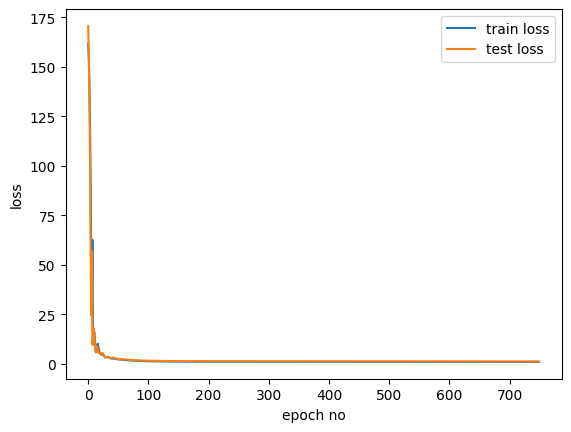

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
#Checking one-step prediction performance of the model
test_target = y_test.cpu().detach().numpy()
test_predictions = []

for i in range(len(test_target)):
  input_ = X_test[i].reshape(1, T, D)
  p = model(input_)[0,0].item()

  # update the predictions list
  test_predictions.append(p)

In [ ]:
plot_len = len(test_predictions)
plot_df = weather[['date', 'mean_temp']].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = test_predictions
plot_df.set_index('date', inplace=True)
plot_df.head(5)

,mean_temp,prediction
date,,
2012-08-27,16.9,17.658951
2012-08-28,19.1,19.220764
2012-08-29,17.1,17.272375
2012-08-30,15.7,15.225909
2012-08-31,12.4,14.959665


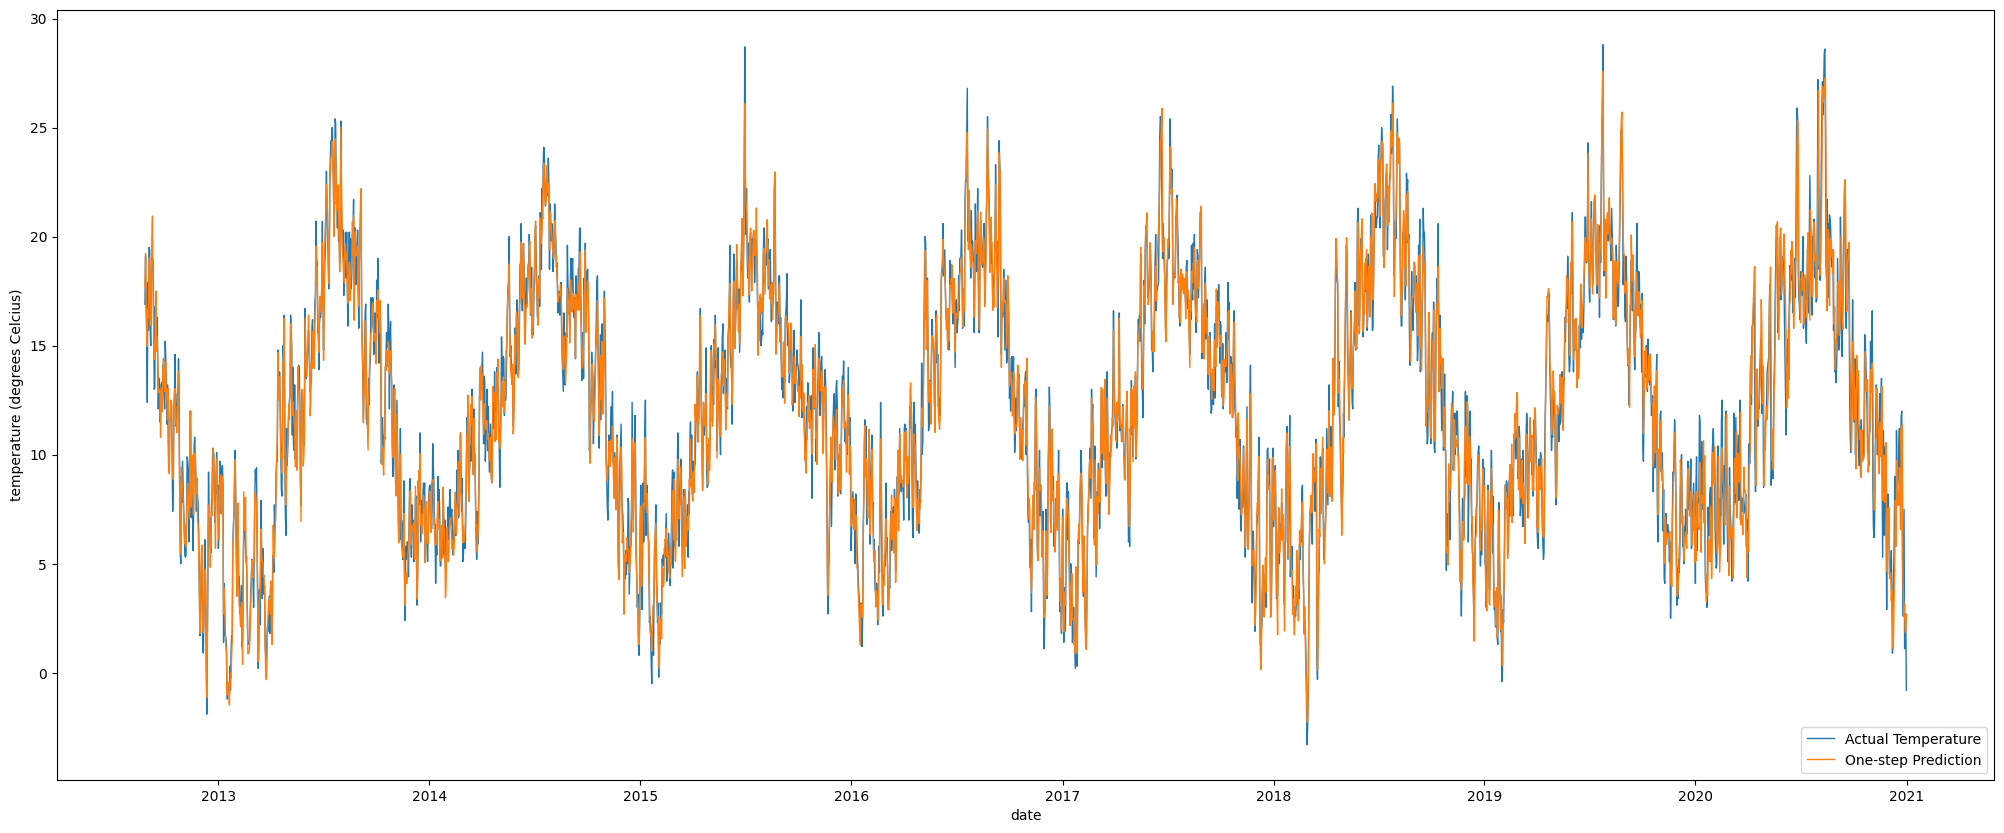

In [ ]:
plt.rcParams['figure.figsize'] = (25.0, 10.0)
plt.plot(plot_df['mean_temp'], label='Actual Temperature', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('temperature (degrees Celcius)')
plt.legend(loc='lower right')

In [ ]:
plot_df.index.year.unique()

Index([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype='int32', name='date')

In [ ]:
plot_df_by_years = []
for y in plot_df.index.year.unique():
    plot_df_by_years += [(y, plot_df.loc[(plot_df.index.year == y)])]

In [ ]:
plot_df_by_years

[(2012,
              mean_temp  prediction
  date                             
  2012-08-27       16.9   17.658951
  2012-08-28       19.1   19.220764
  2012-08-29       17.1   17.272375
  2012-08-30       15.7   15.225909
  2012-08-31       12.4   14.959665
  ...               ...         ...
  2012-12-27        7.2    5.703919
  2012-12-28        9.0    8.786323
  2012-12-29       10.1    9.801254
  2012-12-30        8.2    9.173793
  2012-12-31        8.6    7.779521
  
  [127 rows x 2 columns]),
 (2013,
              mean_temp  prediction
  date                             
  2013-01-01        5.7    6.988176
  2013-01-02        6.5    6.101624
  2013-01-03        8.6    8.682527
  2013-01-04        9.7    8.721300
  2013-01-05        9.4    9.087260
  ...               ...         ...
  2013-12-27        6.3    7.847372
  2013-12-28        6.3    5.990597
  2013-12-29        5.1    6.162457
  2013-12-30        6.4    5.921982
  2013-12-31        8.0    7.183056
  
  [365 rows x 2

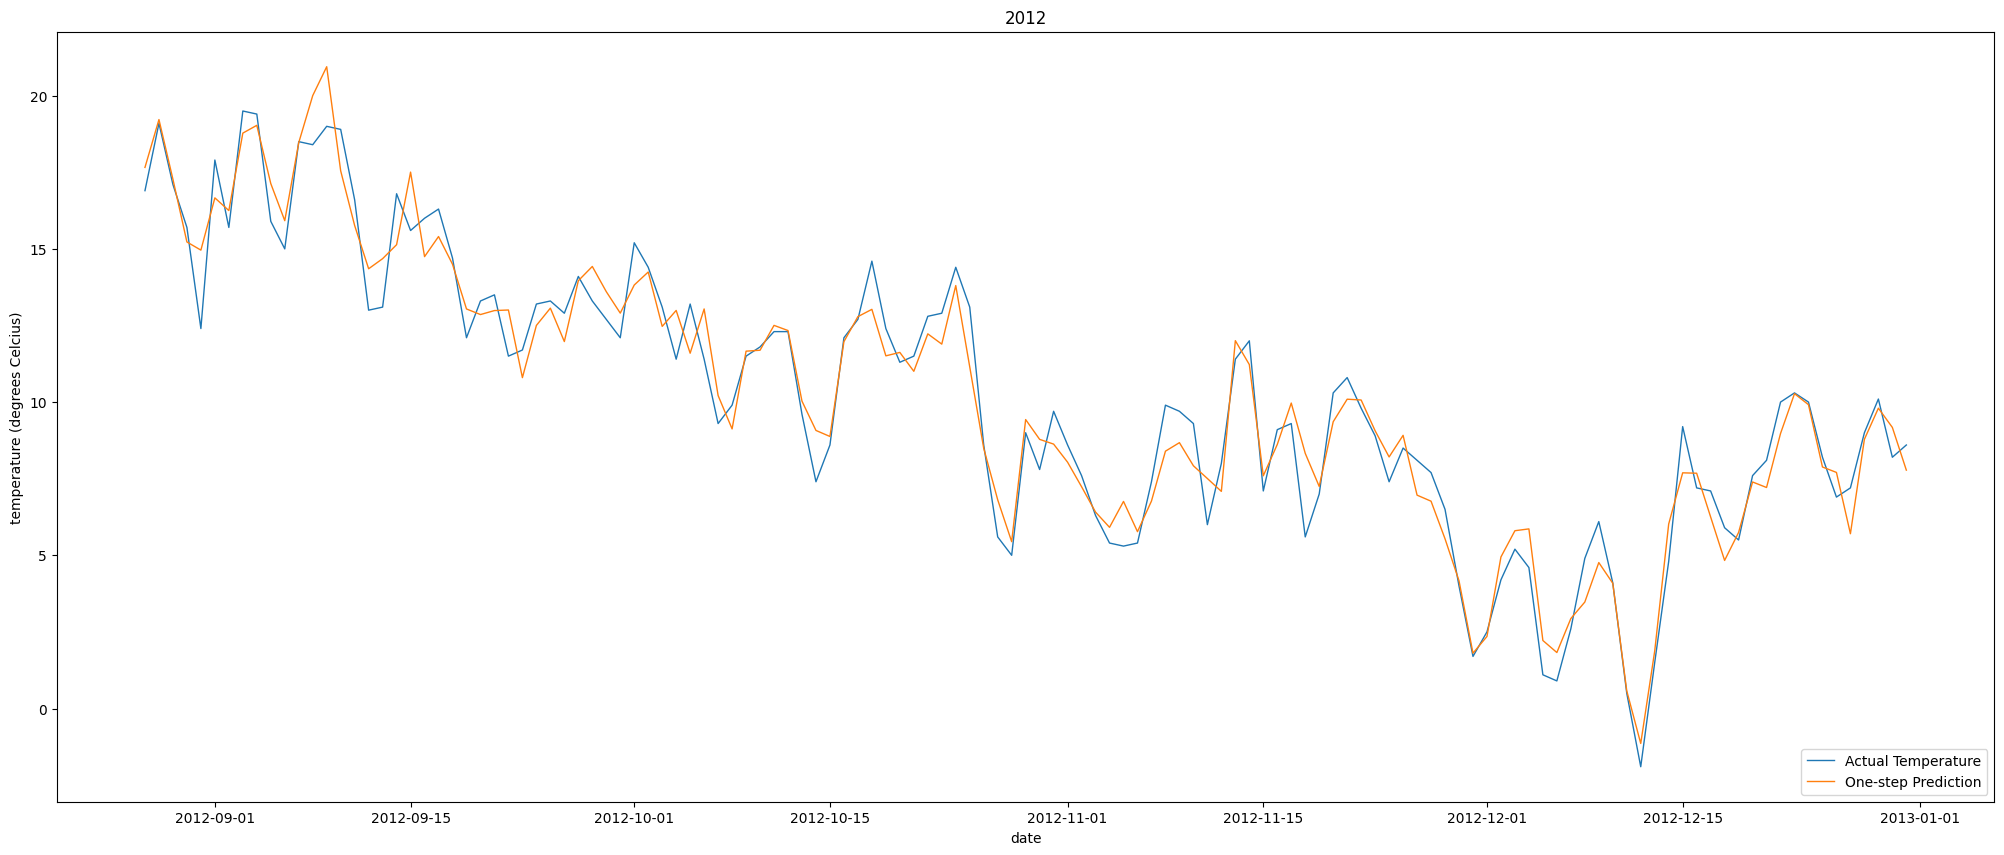

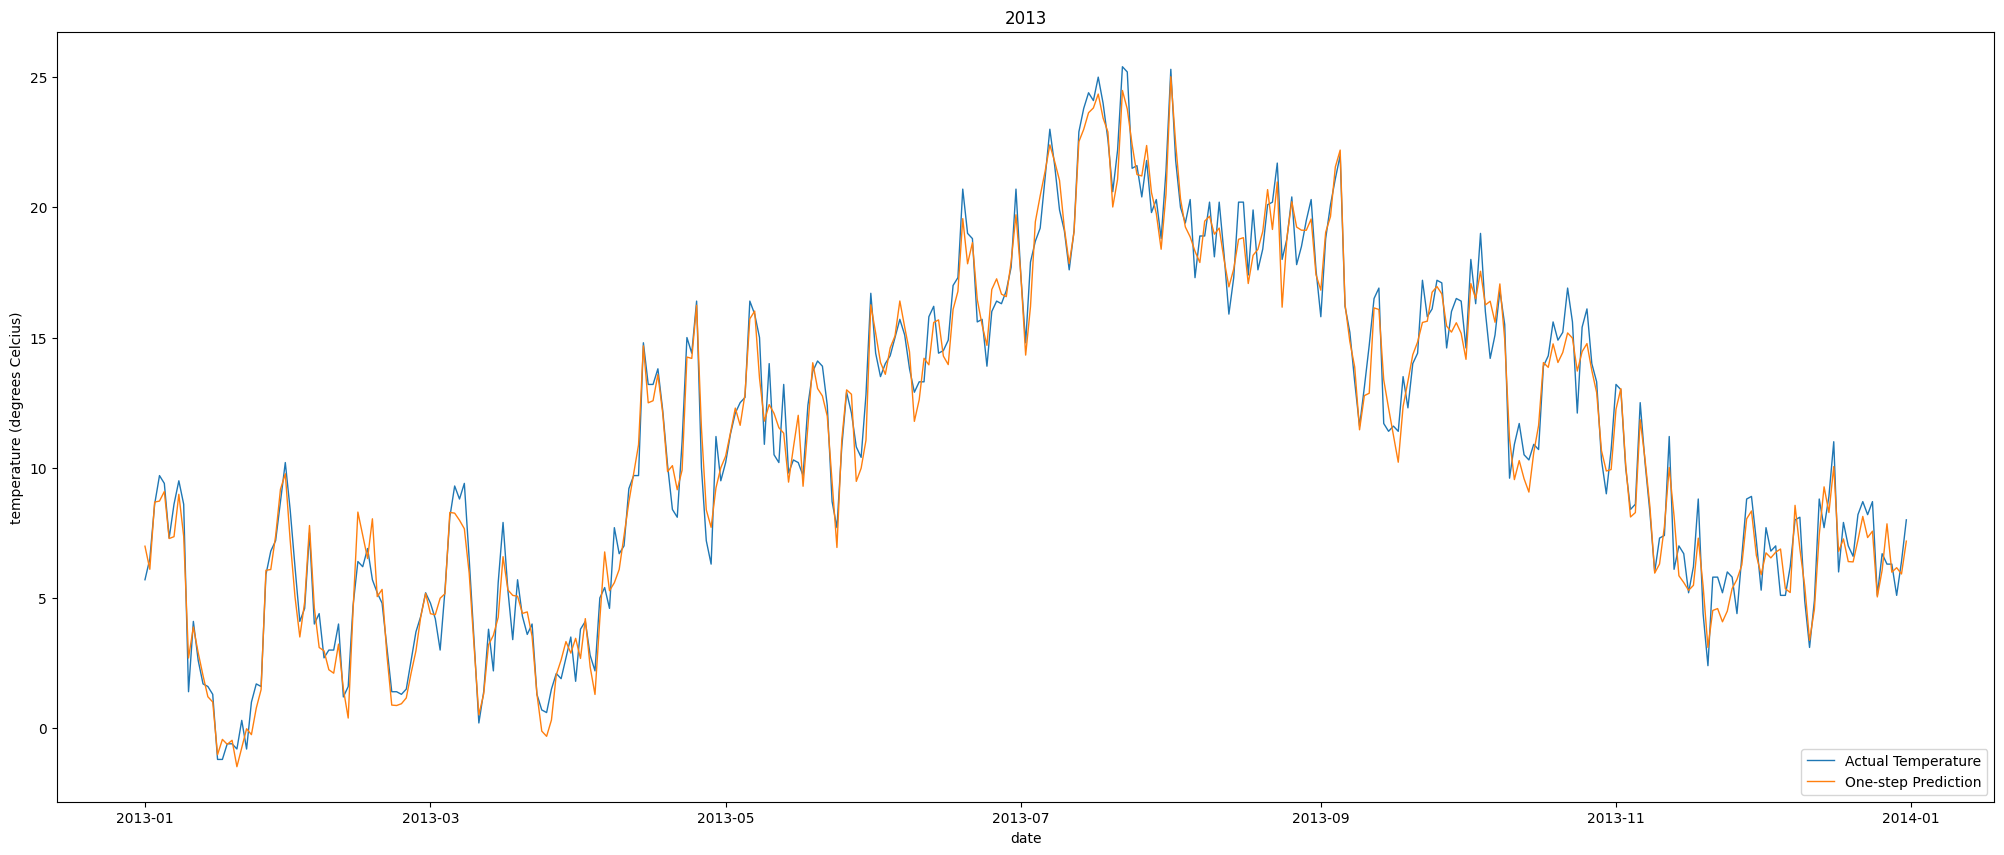

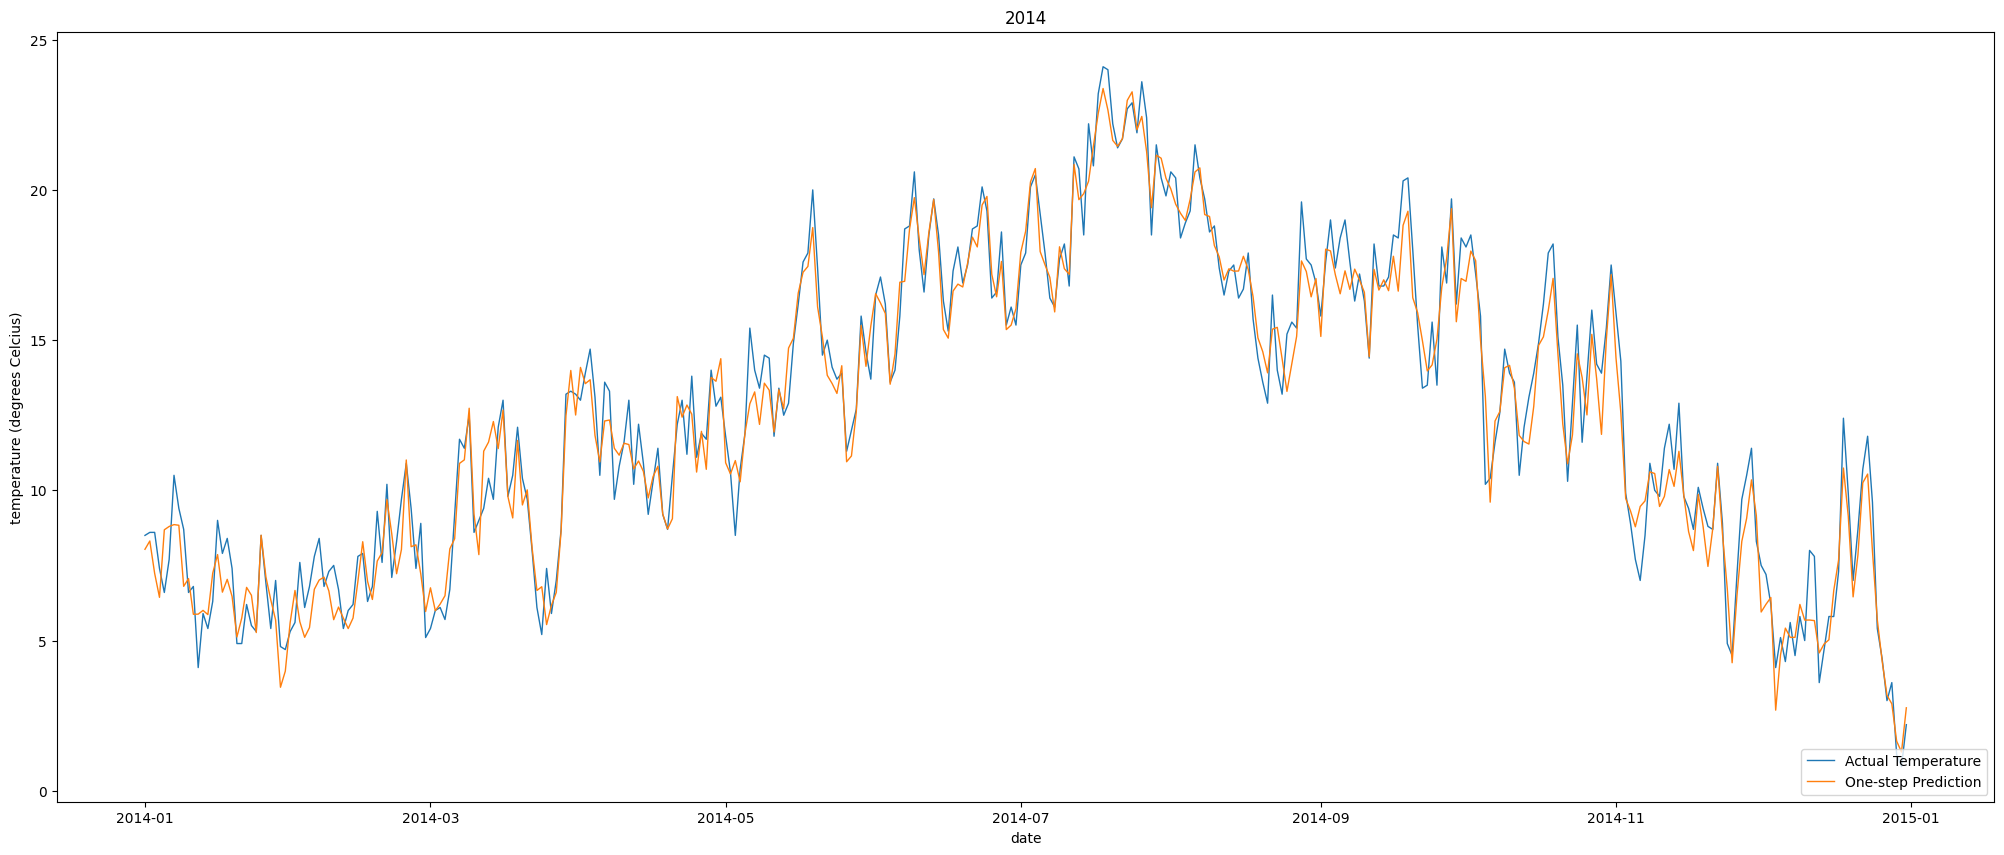

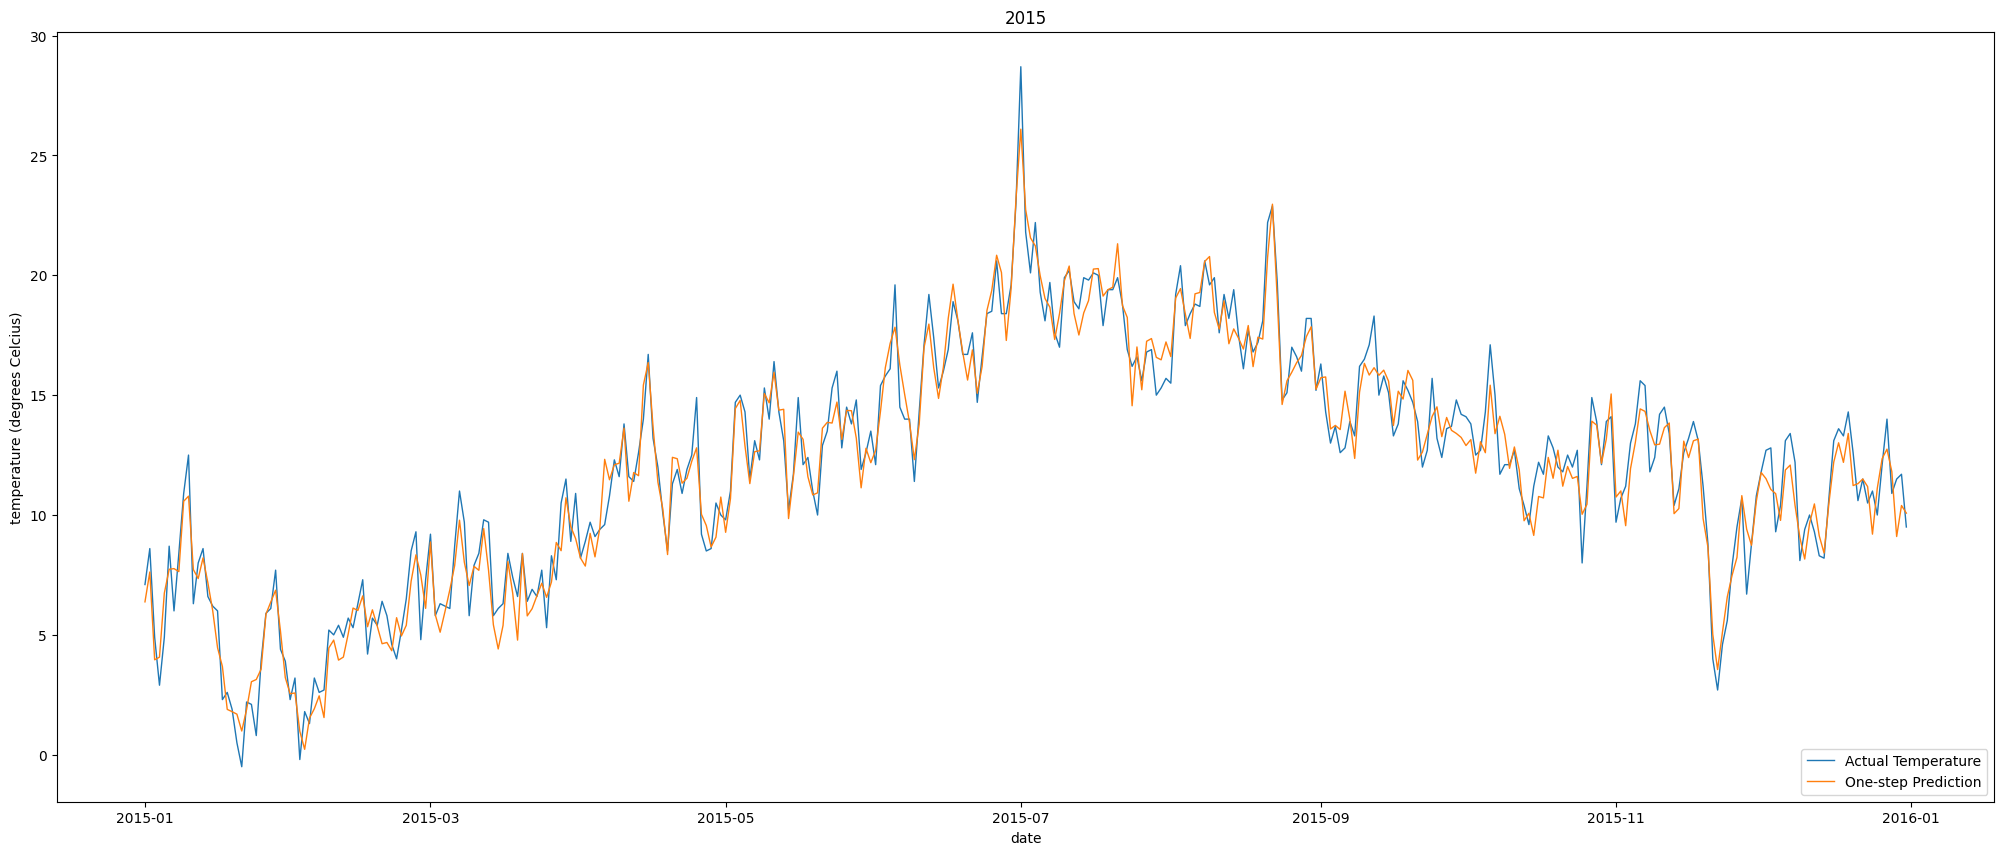

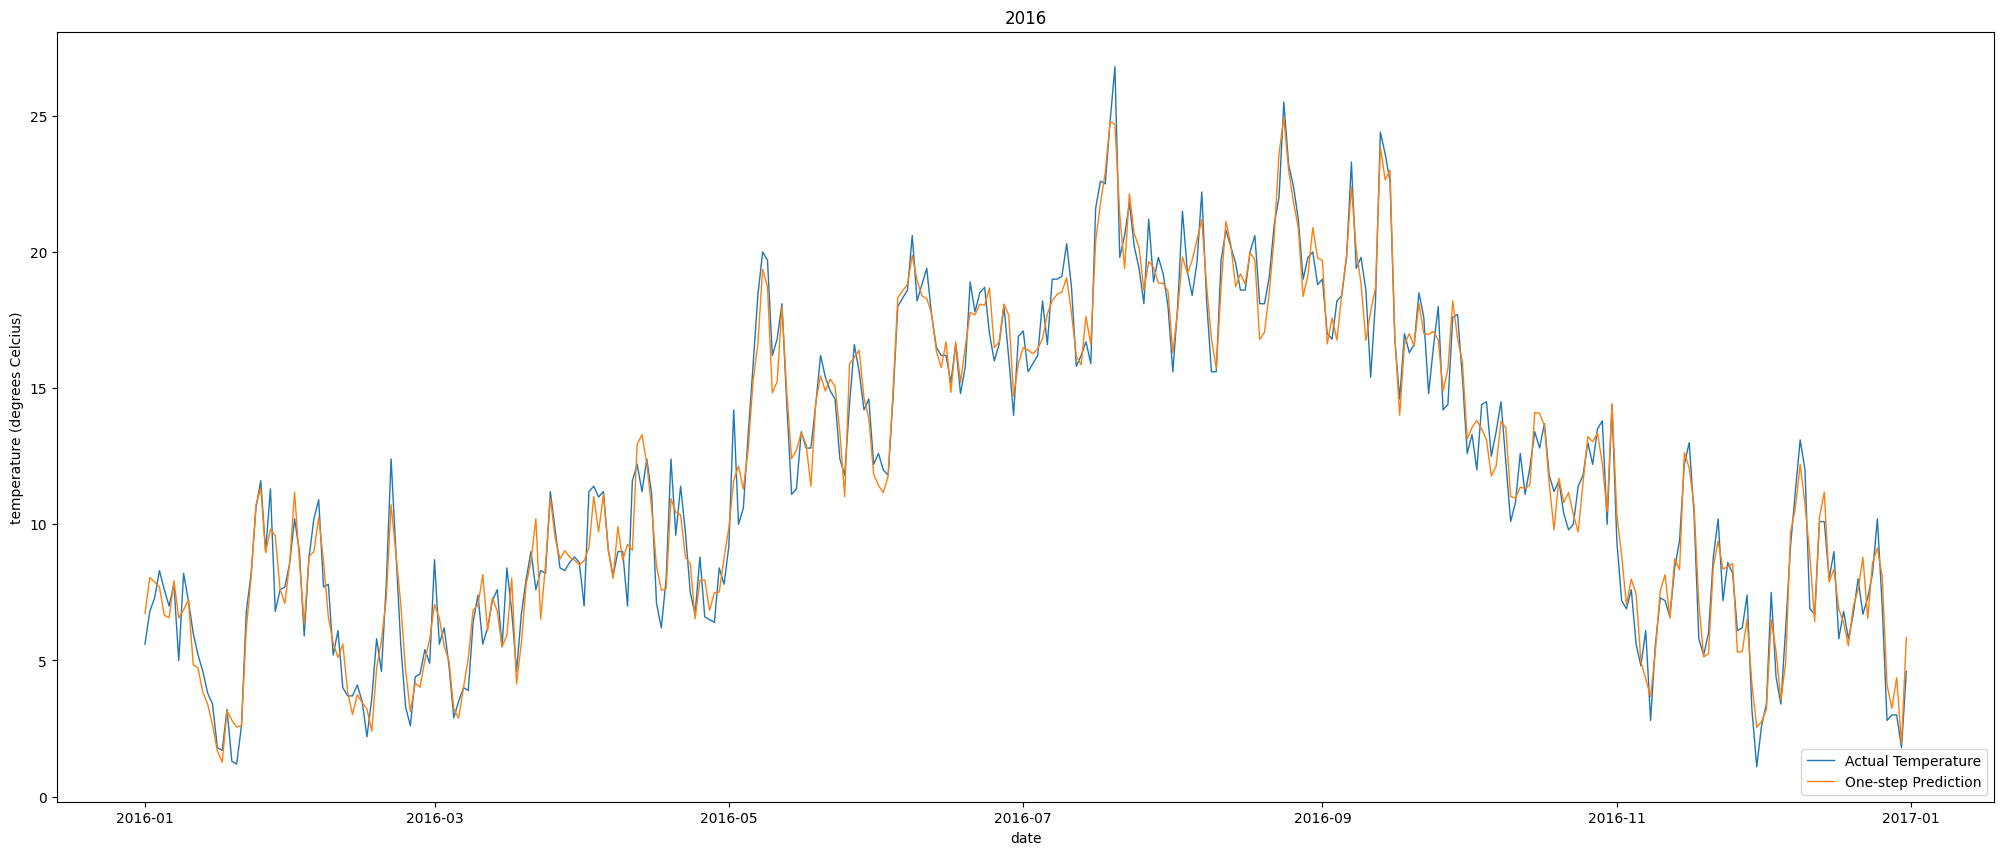

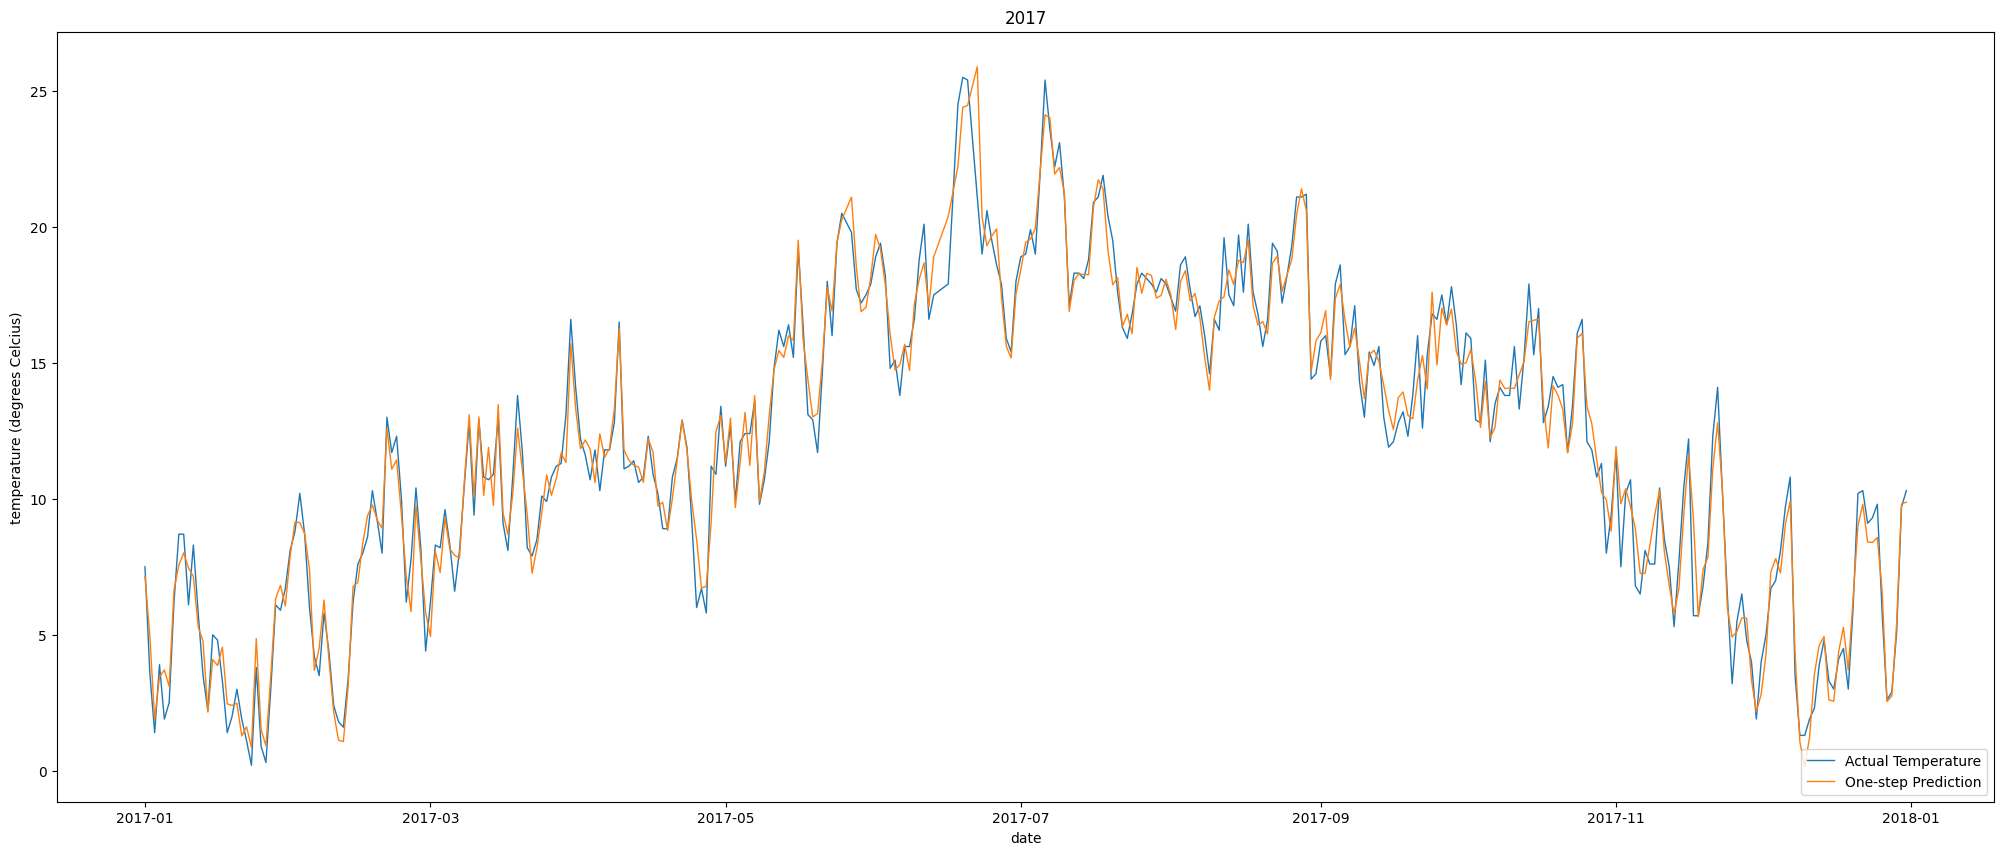

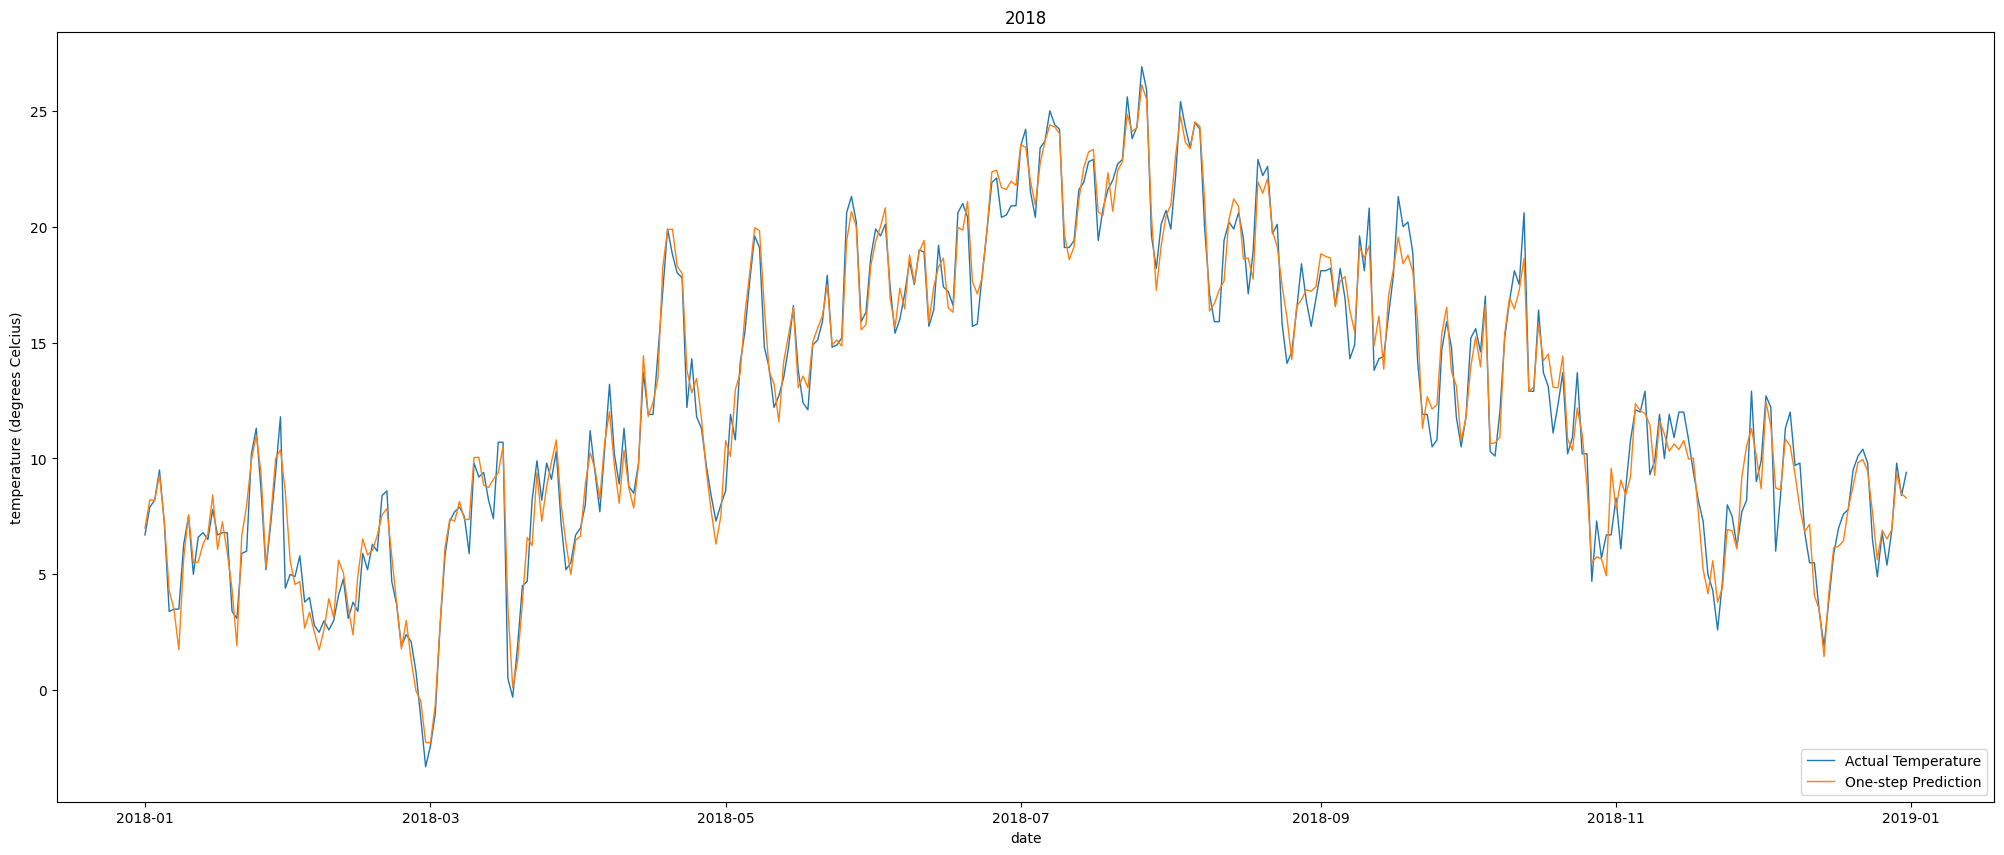

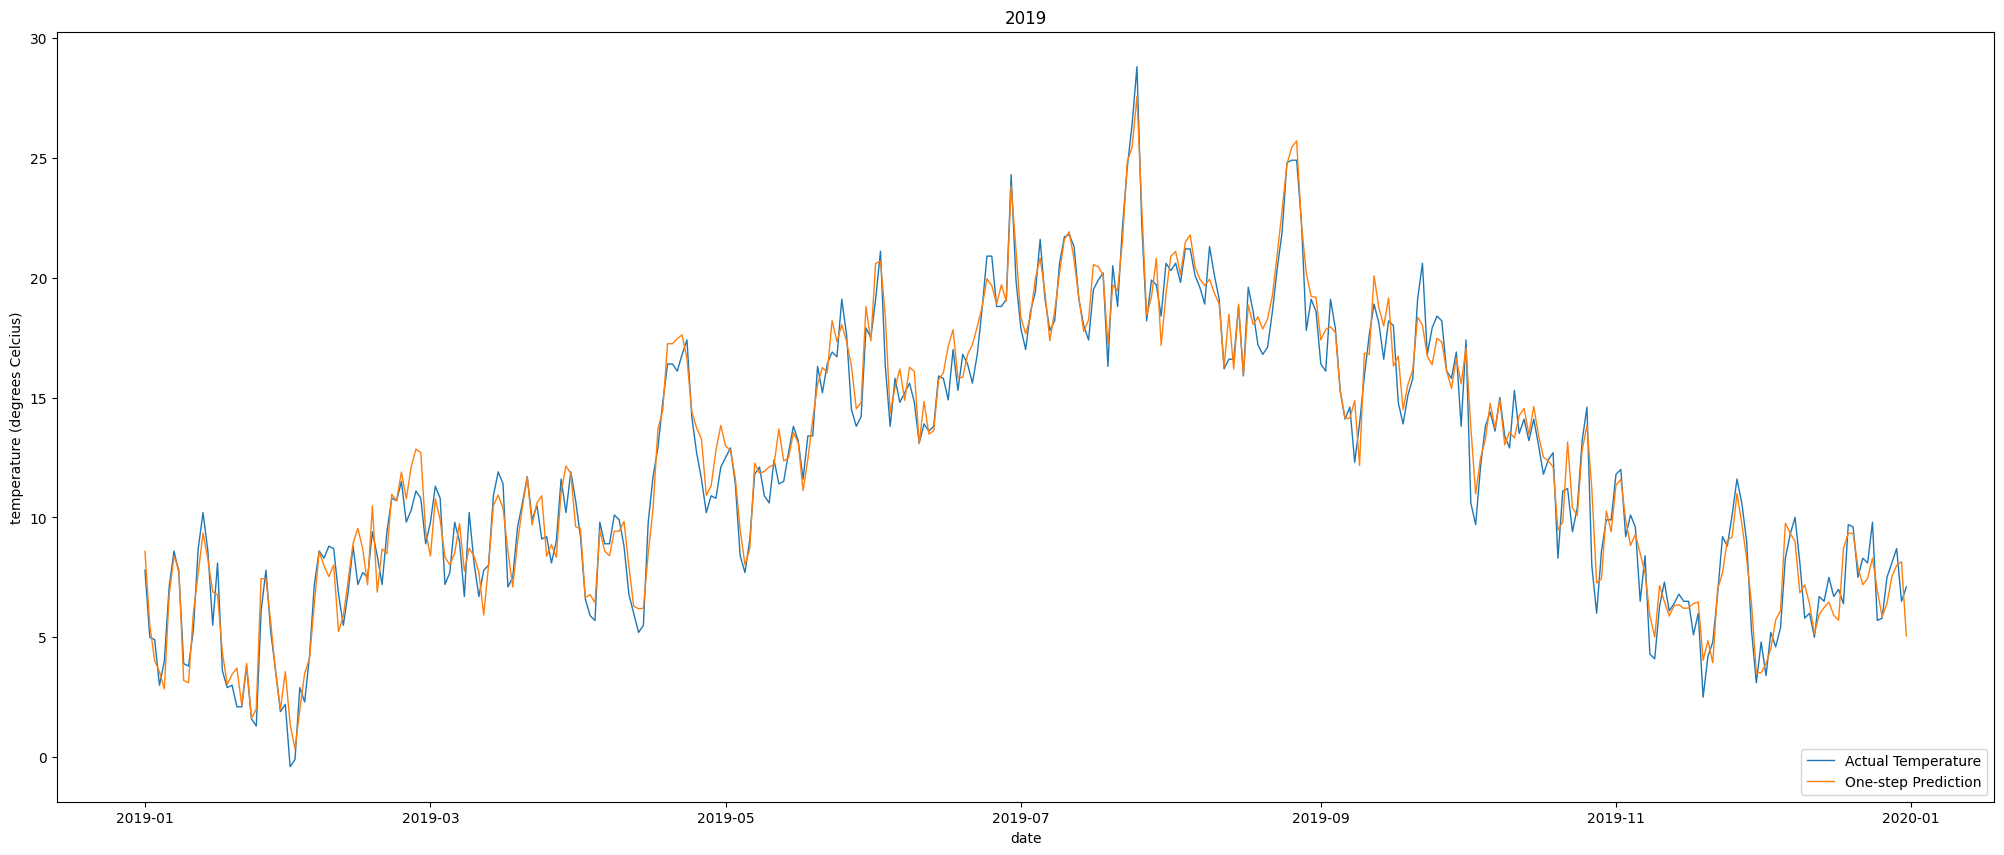

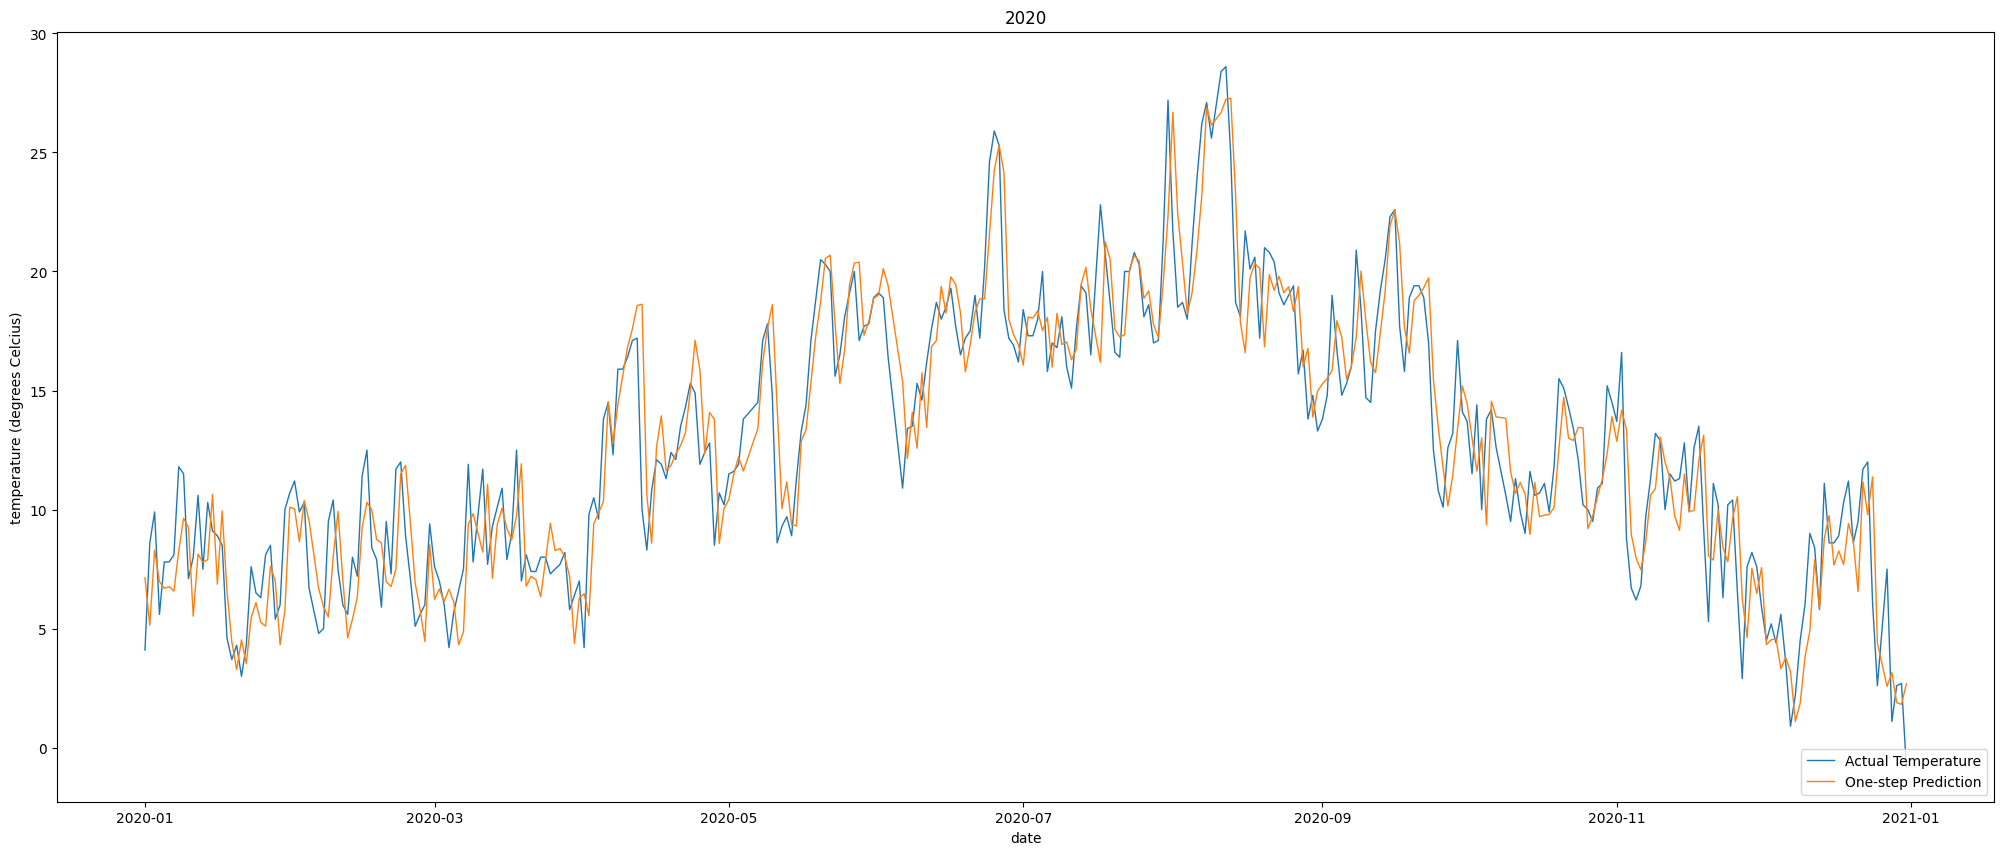

In [ ]:
for pdfby in plot_df_by_years:
    plt.rcParams['figure.figsize'] = (25.0, 10.0)
    plt.plot(pdfby[1]['mean_temp'], label='Actual Temperature', linewidth=1)
    plt.plot(pdfby[1]['prediction'], label='One-step Prediction', linewidth=1)
    plt.xlabel('date')
    plt.ylabel('temperature (degrees Celcius)')
    plt.legend(loc='lower right')
    plt.title(pdfby[0])
    plt.show()

In [ ]:
LTSM_error = pd.DataFrame(test_target, columns = ['targets'])
LTSM_error['predictions'] =test_predictions
LTSM_error['error'] = LTSM_error['targets'] - LTSM_error['predictions']
LTSM_error['error_square'] = LTSM_error['error'] ** 2
err = LTSM_error['error_square'].mean()
print(f'Mean square error is: {err:.3f}')

Mean square error is: 1.321


Text(0.5, 1.0, 'Distribution of Differences')

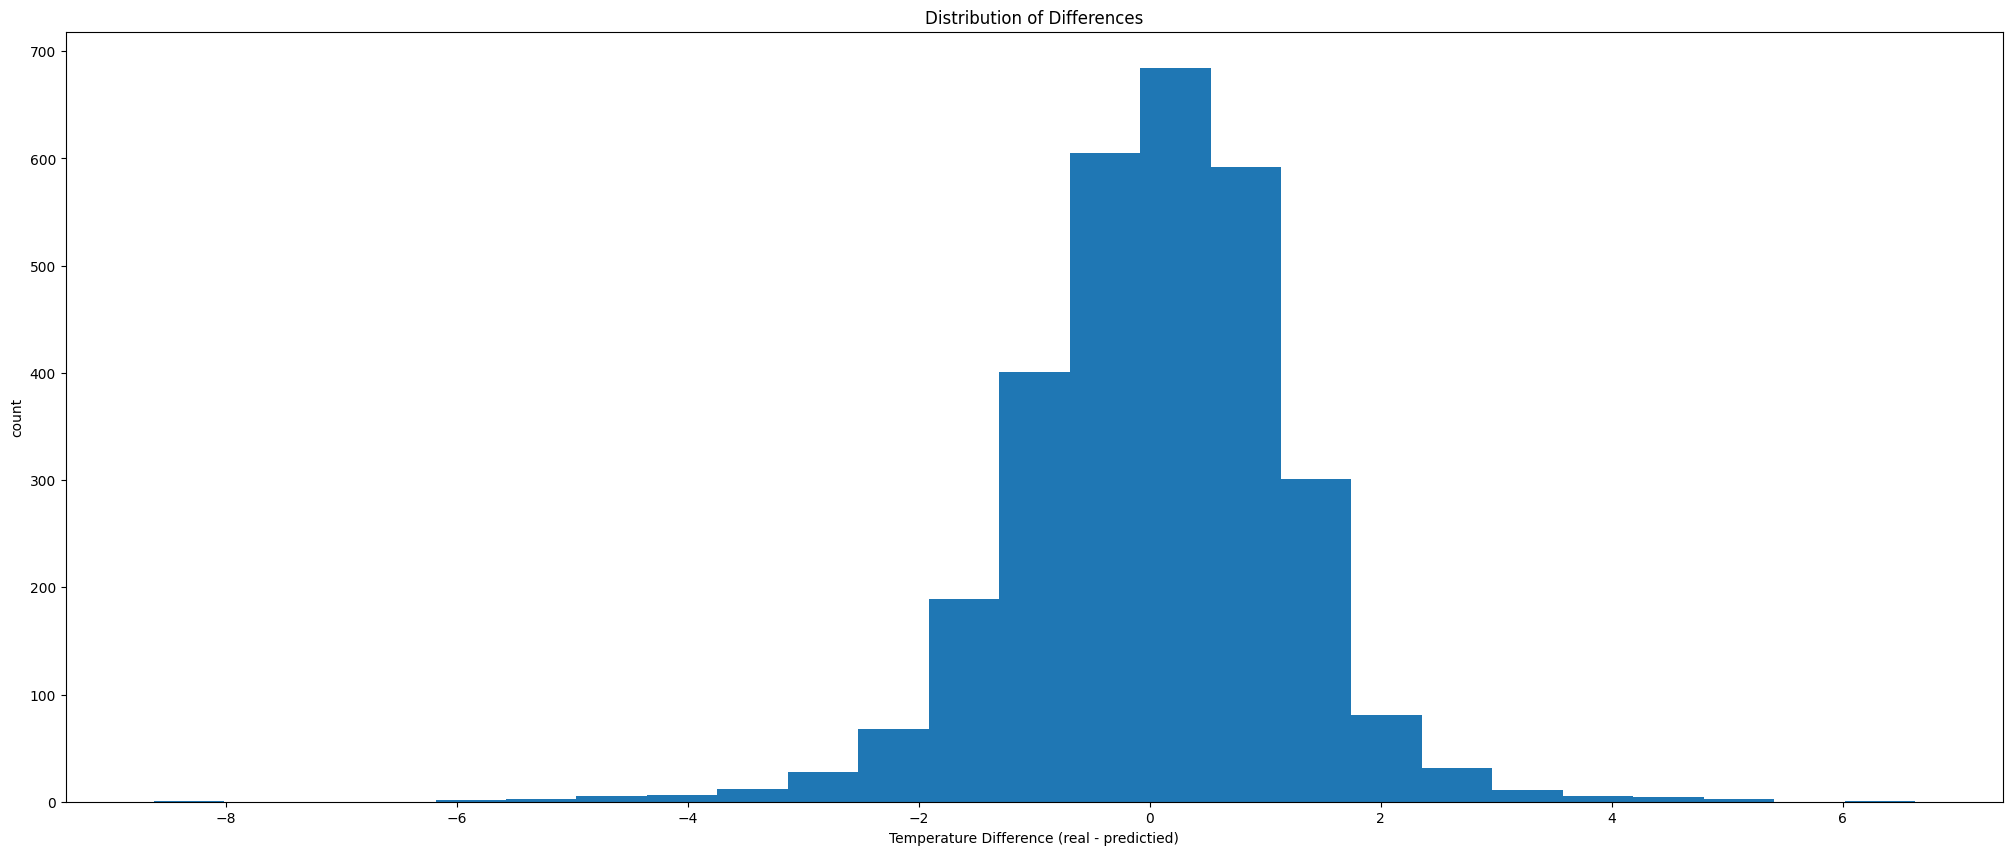

In [ ]:
plt.hist(LTSM_error['error'], bins=25)
plt.xlabel('Temperature Difference (real - predictied)')
plt.ylabel('count')
plt.title('Distribution of Differences')

## 8. Designing the Petri net description

Okay, so you now somewhat have an idea of how to implement the LSTM from scratch. However, if you recall from the coursework specification, you are also required to somehow design the Petri net description of your implementation first! You are now probably asking:

- How would I even model the implementation with Petri nets?
- Is it even possible to implement something so sophisticated with Petri nets?
- Where does the Petri net description come in?
- What use is the Petri net description going to do?
- Why do we not just use FSMs instead of Petri nets? It is much, much simpler! ~~This bullet point is meant to be a joke and the option to use FSMs was never a choice. There are many reasons why a Petri net is preferred, but I am not re-covering this in great detail.~~

Instead of rushing to create the Petri net of the whole implementation (which you do not even have yet!), let us break it into the following steps.

### z. Petri net design in Workcraft.

This is not an actual step, but a quick refresher of what you can do in Workcraft ~~since you probably thought that I will never need to touch this program ever again after submitting the semester 1 coursework~~.

### a. Start small - e.g. What are your 'transitions' and what are your 'places'?

It is important to build up the 'core' skeleton of your model.

<center><img src="step_a.svg" width="35%"></center>

### b. Find its meaning - e.g. What is the meaning of your tokens in these places? What can the tokens represent? Does it make sense?

While tokens generally depict the state of the system, you can sometimes instead give it some value like how we done it for Signal Transition Graphs. For example, we may want a token representing when a datapoint has been pre-processed into a Boolean value.

<center><img src="step_b.svg" width="50%"></center>

### c. Identify what can be refined in your transitions and/or 'eventised' - e.g. What steps are needed to build up the pre-processor process?

The trick to Petri net modelling is not to build the entire thing, but rather build parts of the whole system to eventually be comprised together. This even includes smaller parts of the system, as you will have your 'core' transitions that represent what action/process you want to consider before refining it to include the actual operations needed.

<center><img src="step_c.svg" width="50%"></center>

### d. Check the flow - e.g. Is the token flowing the right direction? Does it indicate that we send the data to the ML model after pre-processing it or not?

When refining your transition, you may often run into a situation where it is no longer compatible with another part of your model and/or it no longer makes sense, due to multiple arcs that fly out everywhere. In these cases, you will need to ensure the flow of tokens is correct so that you know the steps of each process is in the correct order. This even is done so your model is not deadlocked suddenly.

<center><img src="step_d.svg" width="65%"></center>

### e. Validate the behaviour - e.g. Is my Petri net of the pre-processor component doing the right thing?

Creating the Petri net model of any system is great! However, despite it being complete, you still need to check if its behaviour is expected. For example, if you build a complete Petri net of a calculator that suddenly outputs 3 from 1 + 1 when we were expecting 2 then this model is useless and cannot be used anywhere. ~~The message here is if any Petri net component is designed incorrectly, it can have dire consequenes on other Petri net components that rely on it~~.

<center><img src="step_e.svg" width="65%"></center>

### f. Rinse and repeat for each component.

Keep working on your Petri net description of each component and refine it accordingly. There are many operations you may have not thought of yet, but wish to include.

## 9. Concluding remarks

After the next few weeks, you will gradually see how both your Petri net description and your LSTM implementation will evolve over time as you begin to identify more processes to be implemented.

In fact, this process is what we done when building the Tsetlin Machine-Petri net model as illustrated in the diagram below, where we started off from something very simple (e.g. a few transitions that represent the overall operations of a TM) to then refining each transition (e.g. building up the skeleton of loading each data point for the load data transition) and comprising them all together to create the fully functional Petri net model of a Tsetlin Machine.

> **_Remember:_** The point of modelling your work as a Petri net is not to replace your implemented program with a Petri net, but rather to identify and understand the processes involved in your program, how you can break it up into separate processes that can work with one another, how these can then be scaled up in the future, and how it can then be further optimised.

![Diagram illustrating the complete Tsetlin Machine Petri net model](TM_Petrinet.svg)

## 10. Your tasks!

- Identify what will be your *key* processes needed for the LSTM implementation. You probably want to write up some Python definitions as a first step.
- Build up your (initial) Petri net description of the LSTM implementation - Start simple and refine it as you go. I do not expect this to be final straight away.
- Think about how each step in the process is performed and how you should handle it in both the Petri net modelling and the Python implementation, e.g. When pre-processing your data, what were the steps needed? Do I clean the data? Do I remove irrelevant/non-applicable datapoints? Which parts of the data am I concerned with? What do I want the LSTM to learn?